In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, validation_curve
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import multiprocessing
import optuna
import cma

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

In [2]:
m = pd.read_csv("../../data/processed/processed_3.csv")

m

,감독,제작사,배급사,전국 스크린수,전국 관객수,개봉년,국적_기타,국적_독일,국적_러시아,국적_미국,...,장르_어드벤처,장르_전쟁,장르_코미디,장르_판타지,등급_12세이상관람가,등급_15세이상관람가,등급_전체관람가,등급_청소년관람불가,영화구분_독립/예술영화,영화구분_일반영화
0,32994955.0,25901788.0,408568268.0,1587.0,17613682.0,2014,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,20493037.0,16264944.0,408568268.0,1978.0,16264944.0,2019,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,36480785.0,26664001.0,197139226.0,1912.0,14410754.0,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,28965892.0,40748216.0,408568268.0,966.0,14245998.0,2014,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,33853565.0,80052717.0,108716317.0,2835.0,13934592.0,2019,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,27757.0,5960.0,357074.0,166.0,5960.0,2020,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2288,30209.0,30209.0,126229.0,91.0,6876.0,2021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2289,3190.0,449249.0,3190.0,65.0,3190.0,2021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2290,555565.0,458271.0,202280319.0,699.0,360873.0,2021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [3]:
def recursive_feature_elimination(X, y, model, min_features=1, verbose=True):
    # 초기 변수 개수
    n_features = X.shape[1]
    
    # 현재 변수들의 성능
    best_score = float("inf")
    best_features = X.columns.tolist()
    
    # 최소 변수 개수 이상인 경우
    while n_features > min_features:
        # 모든 변수에 대해 반복
        scores = []
        for feature in X.columns:
            # 선택한 변수 제외
            features = X.columns.drop(feature)
            X_new = X[features]
            
            # 모델 학습 및 평가
            model.fit(X_new, y)
            y_pred = model.predict(X_new)
            score = mean_squared_error(y, y_pred)
            scores.append(score)
            
        # 가장 성능이 좋은 변수 선택
        idx = pd.Index(scores).argmin()
        worst_feature = X.columns[idx]
        
        # 변수 제거
        X.drop(worst_feature, axis=1, inplace=True)
        n_features = X.shape[1]
        if verbose:
            print(f"Removing {worst_feature}: {n_features} features left")
        
        # 모든 변수를 제거한 경우
        if n_features == 0:
            break
        
        # 현재 변수 개수에서의 성능이 최선인 경우
        if min(scores) < best_score:
            best_score = min(scores)
            best_features = X.columns.tolist()
        else:
            break
    
    # 최종 선택된 변수들
    return best_features

In [4]:
# ElasticNetCV 모델 객체 생성
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
enet = ElasticNetCV(alphas=alphas, l1_ratio=0.5, cv=5, max_iter=10000)

# 최소 변수 개수 지정
min_features = 5

# 재귀적 변수 제거 수행
X = m.drop("전국 관객수", axis=1)
y = m["전국 관객수"]
selected_features = recursive_feature_elimination(X, y, enet, min_features=min_features)

# 선택된 변수 출력
print(f"{len(selected_features)} features selected:")
print(selected_features)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2378969108703.0, tolerance: 801307861117.5184
  model = cd_fast.enet_coordinate_descent_gram(


Removing 장르_전쟁: 41 features left
Removing 국적_프랑스: 40 features left
41 features selected:
['감독', '제작사', '배급사', '전국 스크린수', '개봉년', '국적_기타', '국적_독일', '국적_러시아', '국적_미국', '국적_스페인', '국적_영국', '국적_일본', '국적_중국', '국적_캐나다', '국적_프랑스', '국적_한국', '장르_SF', '장르_가족', '장르_공연', '장르_공포(호러)', '장르_기타', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_사극', '장르_서부극(웨스턴)', '장르_스릴러', '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_코미디', '장르_판타지', '등급_12세이상관람가', '등급_15세이상관람가', '등급_전체관람가', '등급_청소년관람불가', '영화구분_독립/예술영화', '영화구분_일반영화']


In [5]:
# 데이터 분할
X = m[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# RandomForestRegressor 모델 학습
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# RandomForestRegressor 모델 예측
rf_y_pred = rf.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
mae = mean_absolute_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 714387.7709360154
MAE: 282635.2550188954
R-squared: 0.8269571213553658


In [7]:
def plot_learning_curve(model, X, y, cv=5, scoring="r2"):
    # 학습곡선 계산
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring=scoring,
                                                            train_sizes=np.linspace(0.1, 1.0, 10))

    # 트레이닝, 크로스벨리데이션 평균 계산
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # 학습곡선 시각화
    plt.plot(train_sizes, train_mean, label="트레이닝 점수")
    plt.plot(train_sizes, test_mean, label="검증 점수")
    plt.title(f"{type(model).__name__} 학습곡선")
    plt.xlabel("학습 데이터 수")
    plt.ylabel("성능 점수")
    plt.legend()
    plt.show()

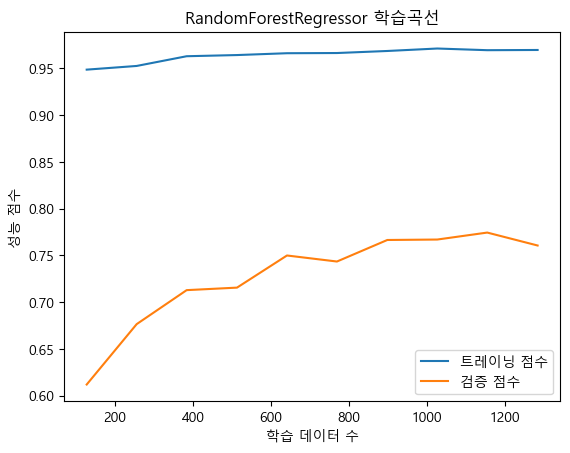

In [8]:
# 학습곡선 그리기
plot_learning_curve(rf, X_train, y_train)

In [9]:
# GradientBoostingRegressor 모델 학습
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

# GradientBoostingRegressor 모델 예측
gb_y_pred = gb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, gb_y_pred, squared=False)
mae = mean_absolute_error(y_test, gb_y_pred)
r2 = r2_score(y_test, gb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 789027.3711151372
MAE: 370771.59640900476
R-squared: 0.7889089374226154


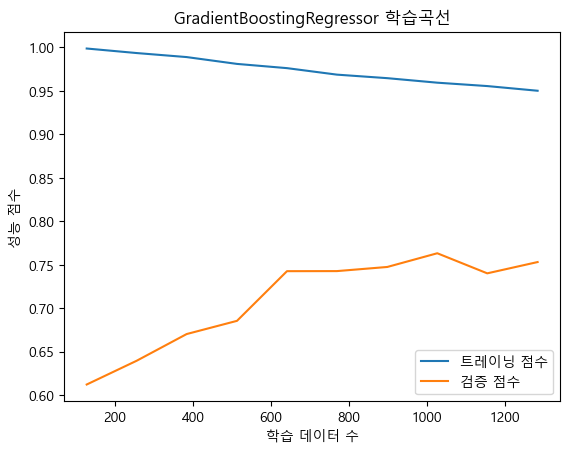

In [10]:
# 학습곡선 그리기
plot_learning_curve(gb, X_train, y_train)

In [11]:
# XGBRegressor 모델 학습
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

# XGBRegressor 모델 예측
xgb_y_pred = xgb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
mae = mean_absolute_error(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 746791.7850843003
MAE: 299637.8896229766
R-squared: 0.810902942083013


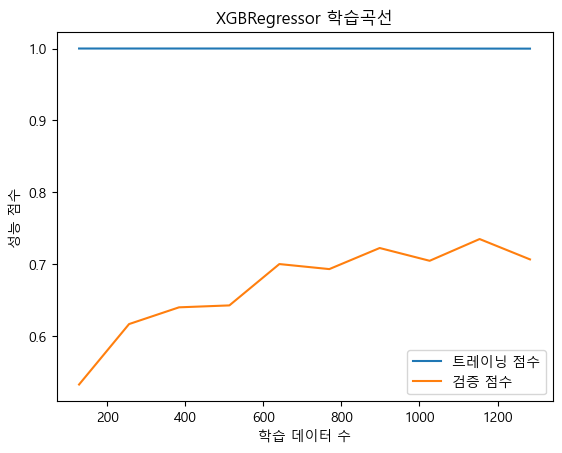

In [12]:
# 학습곡선 그리기
plot_learning_curve(xgb, X_train, y_train)

In [13]:
# LGBMRegressor 모델 학습
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

# LGBMRegressor 모델 예측
lgbm_y_pred = lgbm.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, lgbm_y_pred, squared=False)
mae = mean_absolute_error(y_test, lgbm_y_pred)
r2 = r2_score(y_test, lgbm_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 729075.3390819936
MAE: 299760.6079559894
R-squared: 0.8197685714534738


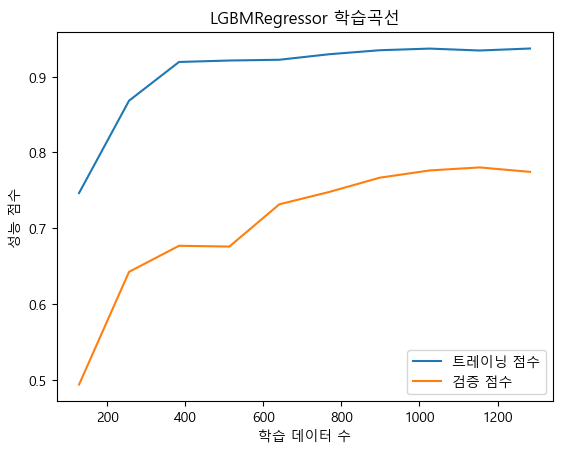

In [14]:
# 학습곡선 그리기
plot_learning_curve(lgbm, X_train, y_train)

In [15]:
# ExtraTreesRegressor 모델 학습
et = ExtraTreesRegressor(random_state=42)
et.fit(X_train, y_train)

# ExtraTreesRegressor 모델 예측
et_y_pred = et.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, et_y_pred, squared=False)
mae = mean_absolute_error(y_test, et_y_pred)
r2 = r2_score(y_test, et_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 761752.3839558195
MAE: 324064.5671947675
R-squared: 0.8032506292302861


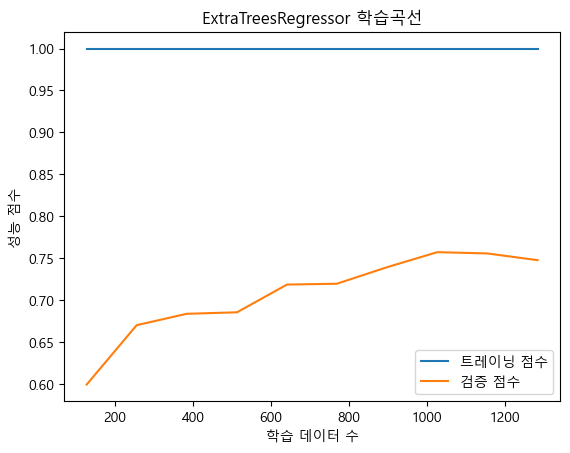

In [16]:
# 학습곡선 그리기
plot_learning_curve(et, X_train, y_train)

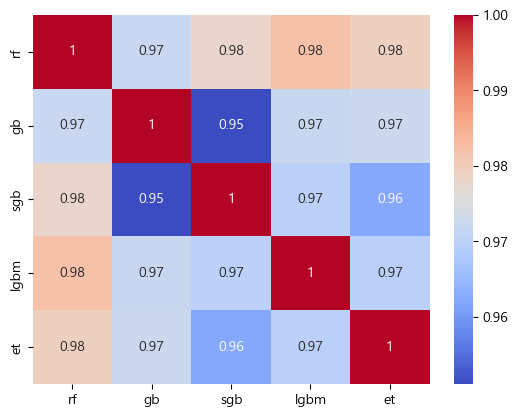

In [17]:
# 각 모델에서 예측한 결과값을 변수로 갖는 데이터프레임 생성
pred_df = pd.DataFrame({
        "rf": rf_y_pred,
        "gb": gb_y_pred,
        "sgb": xgb_y_pred,
        "lgbm": lgbm_y_pred,
        "et" : et_y_pred
    })

# 상관 행렬 계산
corr_matrix = pred_df.corr()

# 시각화
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [18]:
# 메타 모델 선정
models = [rf, gb, xgb, lgbm, et]
best_score = float("-inf")
best_model = None

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    if rmse > best_score:
        best_score = rmse
        best_model = model

print("best_model :", best_model)

# 앙상블 모델 정의
stack = StackingCVRegressor(regressors=(rf, gb, xgb, lgbm, et),
                            meta_regressor=best_model,
                            cv=KFold(n_splits=5, shuffle=True, random_state=42),
                            use_features_in_secondary=True)

# 앙상블 모델 학습
stack.fit(X_train, y_train)

# 앙상블 모델 예측
y_pred = stack.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

best_model : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
RMSE: 810882.8053457212
MAE: 314642.90846753673
R-squared: 0.7770528675964374


C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

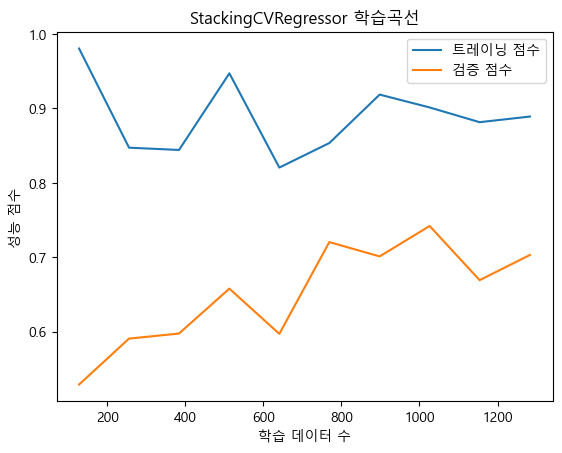

In [19]:
# 학습곡선 그리기
plot_learning_curve(stack, X_train, y_train)

In [20]:
def optimize_model(model_objective, n_trials=100):
    # Bayesian optimization 방식의 하이퍼파라미터 튜닝을 위해 Optuna 라이브러리 사용
    # 최소화를 목적으로 하기 때문에 'minimize'로 설정
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.CmaEsSampler())
    
    # 사용 가능한 모든 CPU 코어 수를 사용하여 병렬 처리
    n_jobs = multiprocessing.cpu_count()  
    
    # 모델 하이퍼파라미터 최적화 실행
    study.optimize(model_objective, n_trials=n_trials, n_jobs=n_jobs)
    
    # 최적 하이퍼파라미터와 그 때의 평가지표 출력
    print(f"Best RMSE: {study.best_value:.4f}")
    print(f"Best Parameters: {study.best_params}")
    
    # 최적 하이퍼파라미터 반환
    return study.best_params

In [21]:
# Random Forest 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    score = cross_val_score(rf, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Random Forest 모델의 하이퍼파라미터 최적화
rf_params = optimize_model(rf_objective)

[I 2023-05-18 15:47:59,954] A new study created in memory with name: no-name-b46e8687-563d-40e8-a926-779ba4c451ae
[I 2023-05-18 15:48:12,601] Trial 4 finished with value: 1946390.988041606 and parameters: {'n_estimators': 200, 'max_depth': 3}. Best is trial 4 with value: 1946390.988041606.
[I 2023-05-18 15:48:16,215] Trial 6 finished with value: 1900414.13964201 and parameters: {'n_estimators': 200, 'max_depth': 4}. Best is trial 6 with value: 1900414.13964201.
[I 2023-05-18 15:48:16,548] Trial 5 finished with value: 1827792.051939437 and parameters: {'n_estimators': 100, 'max_depth': 9}. Best is trial 5 with value: 1827792.051939437.
[I 2023-05-18 15:48:37,606] Trial 1 finished with value: 1882082.6784750575 and parameters: {'n_estimators': 400, 'max_depth': 5}. Best is trial 5 with value: 1827792.051939437.
[I 2023-05-18 15:49:00,204] Trial 2 finished with value: 1900964.8966640981 and parameters: {'n_estimators': 800, 'max_depth': 4}. Best is trial 5 with value: 1827792.051939437.
[

[I 2023-05-18 15:55:10,683] Trial 41 finished with value: 1843067.3863456002 and parameters: {'n_estimators': 900, 'max_depth': 8}. Best is trial 35 with value: 1823651.8865605583.
[I 2023-05-18 15:55:20,721] Trial 50 finished with value: 1880842.8761801776 and parameters: {'n_estimators': 100, 'max_depth': 6}. Best is trial 35 with value: 1823651.8865605583.
[I 2023-05-18 15:55:21,265] Trial 40 finished with value: 1825491.1334109104 and parameters: {'n_estimators': 900, 'max_depth': 9}. Best is trial 35 with value: 1823651.8865605583.
[I 2023-05-18 15:55:32,565] Trial 48 finished with value: 1814582.3217628268 and parameters: {'n_estimators': 300, 'max_depth': 10}. Best is trial 48 with value: 1814582.3217628268.
[I 2023-05-18 15:55:35,168] Trial 45 finished with value: 1879216.1307152116 and parameters: {'n_estimators': 700, 'max_depth': 6}. Best is trial 48 with value: 1814582.3217628268.
[I 2023-05-18 15:55:36,173] Trial 49 finished with value: 1824420.9789827866 and parameters: {

[I 2023-05-18 16:00:57,034] Trial 84 finished with value: 1862493.9760430513 and parameters: {'n_estimators': 800, 'max_depth': 7}. Best is trial 62 with value: 1813040.04504209.
[I 2023-05-18 16:00:59,815] Trial 90 finished with value: 1824420.9789827866 and parameters: {'n_estimators': 300, 'max_depth': 9}. Best is trial 62 with value: 1813040.04504209.
[I 2023-05-18 16:01:04,839] Trial 87 finished with value: 1813567.1968570768 and parameters: {'n_estimators': 500, 'max_depth': 10}. Best is trial 62 with value: 1813040.04504209.
[I 2023-05-18 16:01:10,205] Trial 92 finished with value: 1844505.4887716414 and parameters: {'n_estimators': 200, 'max_depth': 8}. Best is trial 62 with value: 1813040.04504209.
[I 2023-05-18 16:01:39,186] Trial 86 finished with value: 1825550.4509512708 and parameters: {'n_estimators': 800, 'max_depth': 9}. Best is trial 62 with value: 1813040.04504209.
[I 2023-05-18 16:01:46,107] Trial 89 finished with value: 1825434.2028415645 and parameters: {'n_estimat

Best RMSE: 1813040.0450
Best Parameters: {'n_estimators': 400, 'max_depth': 10}


In [22]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
rf.set_params(**rf_params)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
mae = mean_absolute_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 713014.3397702433
MAE: 280513.3490574064
R-squared: 0.8276218416535136


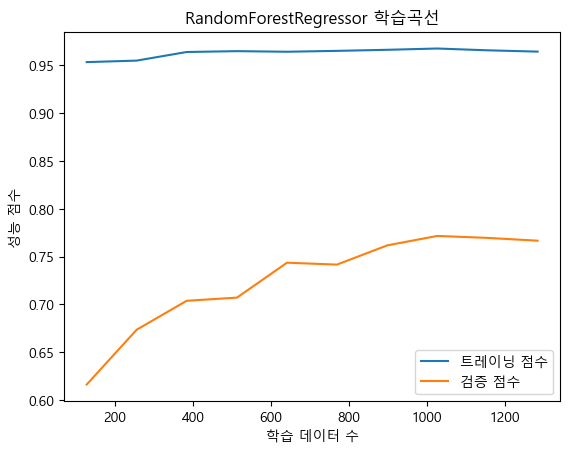

In [23]:
# 학습곡선 그리기
plot_learning_curve(rf, X_train, y_train)

In [24]:
# Gradient Boosting 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def gb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    gb = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                                   max_depth=max_depth, random_state=42)
    score = cross_val_score(gb, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Gradient Boosting 모델의 하이퍼파라미터 최적화
gb_params = optimize_model(gb_objective)

[I 2023-05-18 16:04:25,924] A new study created in memory with name: no-name-ee7328ac-94d9-4d28-8c9e-66624802fcce
[I 2023-05-18 16:04:47,689] Trial 3 finished with value: 1789095.4574853221 and parameters: {'n_estimators': 200, 'learning_rate': 0.04367666218248539, 'max_depth': 7}. Best is trial 3 with value: 1789095.4574853221.
[I 2023-05-18 16:04:55,722] Trial 6 finished with value: 1795823.9339932615 and parameters: {'n_estimators': 600, 'learning_rate': 0.08536650893496882, 'max_depth': 3}. Best is trial 3 with value: 1789095.4574853221.
[I 2023-05-18 16:05:10,769] Trial 7 finished with value: 1794729.1741215724 and parameters: {'n_estimators': 900, 'learning_rate': 0.08537373077553423, 'max_depth': 3}. Best is trial 3 with value: 1789095.4574853221.
[I 2023-05-18 16:05:15,342] Trial 9 finished with value: 1786212.5139894946 and parameters: {'n_estimators': 300, 'learning_rate': 0.0420374255024531, 'max_depth': 4}. Best is trial 9 with value: 1786212.5139894946.
[I 2023-05-18 16:05

[I 2023-05-18 16:07:50,711] Trial 28 finished with value: 1785554.3984971764 and parameters: {'n_estimators': 600, 'learning_rate': 0.06039580675332277, 'max_depth': 6}. Best is trial 14 with value: 1780237.3996221703.
[I 2023-05-18 16:07:55,546] Trial 42 finished with value: 1820457.2455503745 and parameters: {'n_estimators': 100, 'learning_rate': 0.04402703585391549, 'max_depth': 3}. Best is trial 14 with value: 1780237.3996221703.
[I 2023-05-18 16:07:56,197] Trial 43 finished with value: 1794372.303152699 and parameters: {'n_estimators': 100, 'learning_rate': 0.08143809489453813, 'max_depth': 3}. Best is trial 14 with value: 1780237.3996221703.
[I 2023-05-18 16:08:01,753] Trial 38 finished with value: 1789870.903960191 and parameters: {'n_estimators': 500, 'learning_rate': 0.06113479286032383, 'max_depth': 3}. Best is trial 14 with value: 1780237.3996221703.
[I 2023-05-18 16:08:04,094] Trial 39 finished with value: 1786586.326382135 and parameters: {'n_estimators': 300, 'learning_ra

[I 2023-05-18 16:10:18,351] Trial 75 finished with value: 1787205.217212175 and parameters: {'n_estimators': 300, 'learning_rate': 0.0424972771419051, 'max_depth': 4}. Best is trial 14 with value: 1780237.3996221703.
[I 2023-05-18 16:10:19,524] Trial 73 finished with value: 1783812.4302852037 and parameters: {'n_estimators': 400, 'learning_rate': 0.049146596000408944, 'max_depth': 6}. Best is trial 14 with value: 1780237.3996221703.
[I 2023-05-18 16:10:21,163] Trial 66 finished with value: 1783024.2228019487 and parameters: {'n_estimators': 700, 'learning_rate': 0.0562664638943182, 'max_depth': 6}. Best is trial 14 with value: 1780237.3996221703.
[I 2023-05-18 16:10:23,735] Trial 69 finished with value: 1786962.554670348 and parameters: {'n_estimators': 800, 'learning_rate': 0.04799675005430425, 'max_depth': 4}. Best is trial 14 with value: 1780237.3996221703.
[I 2023-05-18 16:10:26,052] Trial 71 finished with value: 1785051.4708755957 and parameters: {'n_estimators': 600, 'learning_ra

Best RMSE: 1778697.2860
Best Parameters: {'n_estimators': 200, 'learning_rate': 0.06320259220477735, 'max_depth': 6}


In [25]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
gb.set_params(**gb_params)
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, gb_y_pred, squared=False)
mae = mean_absolute_error(y_test, gb_y_pred)
r2 = r2_score(y_test, gb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 763262.3907045528
MAE: 306285.03974863637
R-squared: 0.8024698313106075


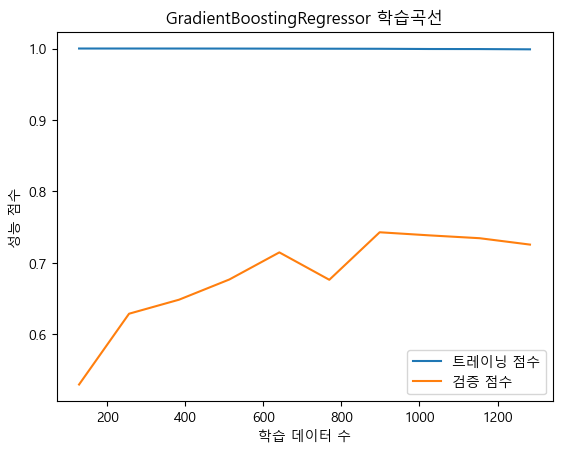

In [26]:
# 학습곡선 그리기
plot_learning_curve(gb, X_train, y_train)

In [27]:
# XGBoost 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def xgb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    xgb = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth=max_depth, subsample=subsample, random_state=42)
    score = cross_val_score(xgb, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse
    
# XGBoost 모델의 하이퍼파라미터 최적화
xgb_params = optimize_model(xgb_objective)

[I 2023-05-18 16:12:25,237] A new study created in memory with name: no-name-f4703a34-e6b6-44b1-b0f2-682e430c371d
[I 2023-05-18 16:12:32,984] Trial 3 finished with value: 1788235.1726168946 and parameters: {'n_estimators': 100, 'learning_rate': 0.08198850690494607, 'max_depth': 7, 'subsample': 0.7801365765993937}. Best is trial 3 with value: 1788235.1726168946.
[I 2023-05-18 16:12:37,976] Trial 5 finished with value: 1815088.1332004734 and parameters: {'n_estimators': 100, 'learning_rate': 0.028371392224906134, 'max_depth': 10, 'subsample': 0.720641830318509}. Best is trial 3 with value: 1788235.1726168946.
[I 2023-05-18 16:12:59,414] Trial 2 finished with value: 1794307.3568400615 and parameters: {'n_estimators': 900, 'learning_rate': 0.008821653002524774, 'max_depth': 3, 'subsample': 0.8347637462397459}. Best is trial 3 with value: 1788235.1726168946.
[I 2023-05-18 16:13:00,748] Trial 6 finished with value: 1778963.4060017194 and parameters: {'n_estimators': 600, 'learning_rate': 0.0

[I 2023-05-18 16:15:30,760] Trial 29 finished with value: 1778216.6057858062 and parameters: {'n_estimators': 600, 'learning_rate': 0.06245443483029285, 'max_depth': 6, 'subsample': 0.6661665272419586}. Best is trial 12 with value: 1772910.5107028424.
[I 2023-05-18 16:15:32,209] Trial 33 finished with value: 1771952.615847403 and parameters: {'n_estimators': 400, 'learning_rate': 0.052890099487219164, 'max_depth': 5, 'subsample': 0.76748071306693}. Best is trial 33 with value: 1771952.615847403.
[I 2023-05-18 16:15:34,936] Trial 34 finished with value: 1772502.1934247257 and parameters: {'n_estimators': 400, 'learning_rate': 0.04433619212142329, 'max_depth': 5, 'subsample': 0.7520199128303489}. Best is trial 33 with value: 1771952.615847403.
[I 2023-05-18 16:15:42,877] Trial 35 finished with value: 1777004.6272214246 and parameters: {'n_estimators': 400, 'learning_rate': 0.043546076911077085, 'max_depth': 6, 'subsample': 0.7479755965589846}. Best is trial 33 with value: 1771952.6158474

[I 2023-05-18 16:18:18,099] Trial 64 finished with value: 1776507.4935222024 and parameters: {'n_estimators': 500, 'learning_rate': 0.07098697762863293, 'max_depth': 5, 'subsample': 0.7796293193349005}. Best is trial 33 with value: 1771952.615847403.
[I 2023-05-18 16:18:21,384] Trial 65 finished with value: 1778595.7801177194 and parameters: {'n_estimators': 600, 'learning_rate': 0.05059793961906372, 'max_depth': 4, 'subsample': 0.8886920846382984}. Best is trial 33 with value: 1771952.615847403.
[I 2023-05-18 16:18:21,469] Trial 62 finished with value: 1780684.4785312868 and parameters: {'n_estimators': 700, 'learning_rate': 0.0620488655533063, 'max_depth': 5, 'subsample': 0.7178187106553827}. Best is trial 33 with value: 1771952.615847403.
[I 2023-05-18 16:18:24,791] Trial 68 finished with value: 1773733.2985686825 and parameters: {'n_estimators': 600, 'learning_rate': 0.04836420011165579, 'max_depth': 3, 'subsample': 0.9184349033256153}. Best is trial 33 with value: 1771952.61584740

[I 2023-05-18 16:20:44,330] Trial 95 finished with value: 1772984.5950442688 and parameters: {'n_estimators': 800, 'learning_rate': 0.062060175210149914, 'max_depth': 3, 'subsample': 0.8705213513280585}. Best is trial 89 with value: 1769198.7246990153.
[I 2023-05-18 16:20:46,513] Trial 97 finished with value: 1780536.063760845 and parameters: {'n_estimators': 600, 'learning_rate': 0.04689533230884699, 'max_depth': 4, 'subsample': 0.7568733526365748}. Best is trial 89 with value: 1769198.7246990153.
[I 2023-05-18 16:20:50,620] Trial 99 finished with value: 1775041.4957137702 and parameters: {'n_estimators': 900, 'learning_rate': 0.06300893629387085, 'max_depth': 3, 'subsample': 0.8344262861035378}. Best is trial 89 with value: 1769198.7246990153.
[I 2023-05-18 16:20:51,746] Trial 96 finished with value: 1775434.0843912945 and parameters: {'n_estimators': 700, 'learning_rate': 0.04580425751867958, 'max_depth': 5, 'subsample': 0.8436735724362454}. Best is trial 89 with value: 1769198.7246

Best RMSE: 1769198.7247
Best Parameters: {'n_estimators': 800, 'learning_rate': 0.06273124439808005, 'max_depth': 3, 'subsample': 0.8797415469961332}


In [28]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
xgb.set_params(**xgb_params)
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
mae = mean_absolute_error(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 763281.5391771886
MAE: 344358.1065563934
R-squared: 0.8024599200441235


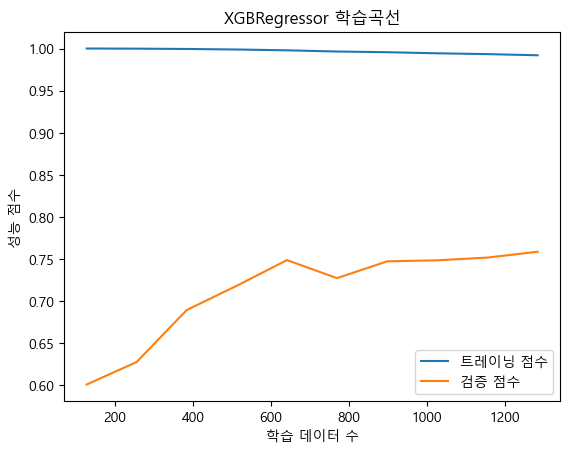

In [29]:
# 학습곡선 그리기
plot_learning_curve(xgb, X_train, y_train)

In [30]:
# LightGBM 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def lgbm_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    num_leaves = trial.suggest_int("num_leaves", 10, 100)
    lgbm = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
    max_depth=max_depth, num_leaves=num_leaves, random_state=42)
    score = cross_val_score(lgbm, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# LightGBM 모델의 하이퍼파라미터 최적화
lgbm_params = optimize_model(lgbm_objective)

[I 2023-05-18 16:21:49,641] A new study created in memory with name: no-name-bc3c5c55-e426-483f-8c42-136624006cfa
[I 2023-05-18 16:21:53,299] Trial 6 finished with value: 1881293.1131091656 and parameters: {'n_estimators': 100, 'learning_rate': 0.012521010118461275, 'max_depth': 8, 'num_leaves': 50}. Best is trial 6 with value: 1881293.1131091656.
[I 2023-05-18 16:21:53,357] Trial 2 finished with value: 1773806.9910798168 and parameters: {'n_estimators': 400, 'learning_rate': 0.07483051816385686, 'max_depth': 5, 'num_leaves': 48}. Best is trial 2 with value: 1773806.9910798168.
[I 2023-05-18 16:21:54,162] Trial 7 finished with value: 1776380.8093544438 and parameters: {'n_estimators': 500, 'learning_rate': 0.06999517956091975, 'max_depth': 5, 'num_leaves': 78}. Best is trial 2 with value: 1773806.9910798168.
[I 2023-05-18 16:21:54,511] Trial 1 finished with value: 1775551.0345271544 and parameters: {'n_estimators': 200, 'learning_rate': 0.0710825668226035, 'max_depth': 10, 'num_leaves'

[I 2023-05-18 16:22:26,119] Trial 33 finished with value: 1782929.1431613013 and parameters: {'n_estimators': 600, 'learning_rate': 0.02655935693032033, 'max_depth': 8, 'num_leaves': 19}. Best is trial 2 with value: 1773806.9910798168.
[I 2023-05-18 16:22:28,482] Trial 40 finished with value: 1776013.9871258603 and parameters: {'n_estimators': 700, 'learning_rate': 0.05016576436915574, 'max_depth': 4, 'num_leaves': 44}. Best is trial 2 with value: 1773806.9910798168.
[I 2023-05-18 16:22:28,677] Trial 35 finished with value: 1775962.5522454842 and parameters: {'n_estimators': 600, 'learning_rate': 0.020286713734165806, 'max_depth': 9, 'num_leaves': 24}. Best is trial 2 with value: 1773806.9910798168.
[I 2023-05-18 16:22:28,895] Trial 36 finished with value: 1775806.8844039992 and parameters: {'n_estimators': 500, 'learning_rate': 0.05480573954307945, 'max_depth': 9, 'num_leaves': 33}. Best is trial 2 with value: 1773806.9910798168.
[I 2023-05-18 16:22:29,518] Trial 34 finished with valu

[I 2023-05-18 16:22:53,105] Trial 66 finished with value: 1776712.5213139355 and parameters: {'n_estimators': 700, 'learning_rate': 0.023664231819203373, 'max_depth': 5, 'num_leaves': 25}. Best is trial 46 with value: 1771234.3965600939.
[I 2023-05-18 16:22:53,720] Trial 71 finished with value: 1774546.495065752 and parameters: {'n_estimators': 800, 'learning_rate': 0.06946928018712414, 'max_depth': 3, 'num_leaves': 73}. Best is trial 46 with value: 1771234.3965600939.
[I 2023-05-18 16:22:54,673] Trial 64 finished with value: 1780547.1189297733 and parameters: {'n_estimators': 800, 'learning_rate': 0.036339399956663444, 'max_depth': 6, 'num_leaves': 48}. Best is trial 46 with value: 1771234.3965600939.
[I 2023-05-18 16:22:54,784] Trial 72 finished with value: 1777220.0737752107 and parameters: {'n_estimators': 700, 'learning_rate': 0.06881062771187048, 'max_depth': 4, 'num_leaves': 39}. Best is trial 46 with value: 1771234.3965600939.
[I 2023-05-18 16:22:55,313] Trial 68 finished with 

[I 2023-05-18 16:23:19,289] Trial 99 finished with value: 1782598.6479783484 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07122782900213202, 'max_depth': 7, 'num_leaves': 74}. Best is trial 95 with value: 1769776.0577709784.


Best RMSE: 1769776.0578
Best Parameters: {'n_estimators': 800, 'learning_rate': 0.08263854884048479, 'max_depth': 4, 'num_leaves': 60}


In [31]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
lgbm.set_params(**lgbm_params)
lgbm.fit(X_train, y_train)
lgbm_y_pred = lgbm.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, lgbm_y_pred, squared=False)
mae = mean_absolute_error(y_test, lgbm_y_pred)
r2 = r2_score(y_test, lgbm_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 743852.2367399619
MAE: 338463.5563904546
R-squared: 0.8123886733317355


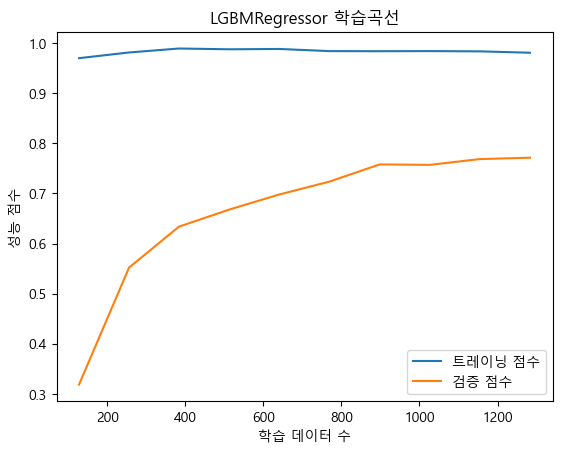

In [32]:
# 학습곡선 그리기
plot_learning_curve(lgbm, X_train, y_train)

In [33]:
# Extra Trees Regressor 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def et_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    et = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                             min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                             random_state=42)
    score = cross_val_score(et, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Extra Trees Regressor 모델의 하이퍼파라미터 최적화
et_params = optimize_model(et_objective)

[I 2023-05-18 16:23:28,852] A new study created in memory with name: no-name-b81c2e8a-6230-4a0c-aa2d-5204e98e972b
[I 2023-05-18 16:23:33,715] Trial 7 finished with value: 1955715.067336416 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 7 with value: 1955715.067336416.
[I 2023-05-18 16:23:33,771] Trial 4 finished with value: 1957563.9906158468 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 7 with value: 1955715.067336416.
[I 2023-05-18 16:23:37,237] Trial 3 finished with value: 1849646.470895446 and parameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 3 with value: 1849646.470895446.
[I 2023-05-18 16:23:38,804] Trial 5 finished with value: 1848482.14360977 and parameters: {'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 5 with value: 1848482.1

[I 2023-05-18 16:25:55,316] Trial 36 finished with value: 1835905.9652638198 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 34 with value: 1824314.0302848853.
[I 2023-05-18 16:25:55,970] Trial 38 finished with value: 1845049.9341040682 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 34 with value: 1824314.0302848853.
[I 2023-05-18 16:26:00,502] Trial 32 finished with value: 1822236.9313903293 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 32 with value: 1822236.9313903293.
[I 2023-05-18 16:26:01,585] Trial 31 finished with value: 1833529.1778308507 and parameters: {'n_estimators': 600, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 32 with value: 1822236.9313903293.
[I 2023-05-18 16:26:06,086] Trial 39 finished with value: 1842630.87127806 and paramet

[I 2023-05-18 16:28:31,697] Trial 64 finished with value: 1835127.8212542203 and parameters: {'n_estimators': 800, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 52 with value: 1818599.8454567797.
[I 2023-05-18 16:28:34,448] Trial 68 finished with value: 1821494.5090645966 and parameters: {'n_estimators': 600, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 52 with value: 1818599.8454567797.
[I 2023-05-18 16:28:52,808] Trial 76 finished with value: 1844813.2723245188 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 52 with value: 1818599.8454567797.
[I 2023-05-18 16:28:55,280] Trial 73 finished with value: 1833305.6937757775 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 52 with value: 1818599.8454567797.
[I 2023-05-18 16:28:56,111] Trial 72 finished with value: 1842885.7881313395 and paramet

Best RMSE: 1813463.5130
Best Parameters: {'n_estimators': 700, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2}


In [34]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
et.set_params(**et_params)
et.fit(X_train, y_train)
et_y_pred = et.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, et_y_pred, squared=False)
mae = mean_absolute_error(y_test, et_y_pred)
r2 = r2_score(y_test, et_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 737579.7350354393
MAE: 325609.2486071117
R-squared: 0.8155393817201945


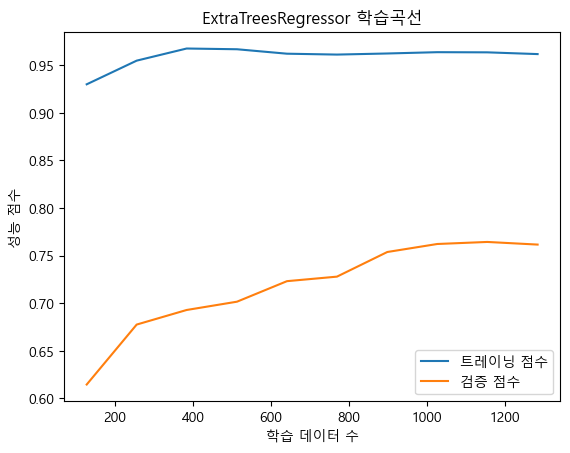

In [35]:
# 학습곡선 그리기
plot_learning_curve(et, X_train, y_train)

In [36]:
# 메타 모델 선정
models = [rf, gb, xgb, lgbm, et]
best_score = float("-inf")
best_model = None

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    if rmse > best_score:
        best_score = rmse
        best_model = model

print("best_model :", best_model)

# 앙상블 모델 정의
stack = StackingCVRegressor(regressors=(rf, gb, xgb, lgbm, et),
                            meta_regressor=best_model,
                            cv=KFold(n_splits=5, shuffle=True, random_state=42),
                            use_features_in_secondary=True)

# 앙상블 모델 학습
stack.fit(X_train, y_train)

# 앙상블 모델 예측
y_pred = stack.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

best_model : GradientBoostingRegressor(learning_rate=0.06320259220477735, max_depth=6,
                          n_estimators=200, random_state=42)


C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


RMSE: 856782.0798804207
MAE: 330457.4809271876
R-squared: 0.7510991058485815


C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but ExtraTreesRegressor was fitt

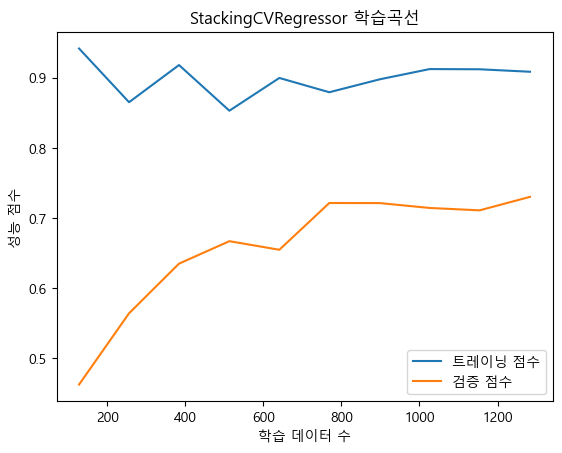

In [37]:
# 학습곡선 그리기
plot_learning_curve(stack, X_train, y_train)

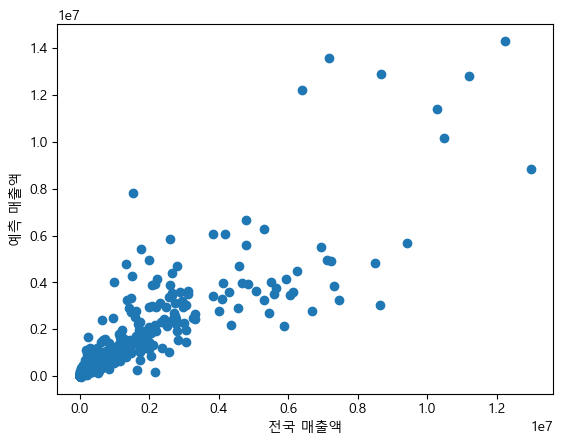

In [38]:
plt.scatter(y_test, y_pred)
plt.xlabel('전국 매출액')
plt.ylabel('예측 매출액')
plt.show()

<Axes: xlabel='year-month', ylabel='reward amount'>

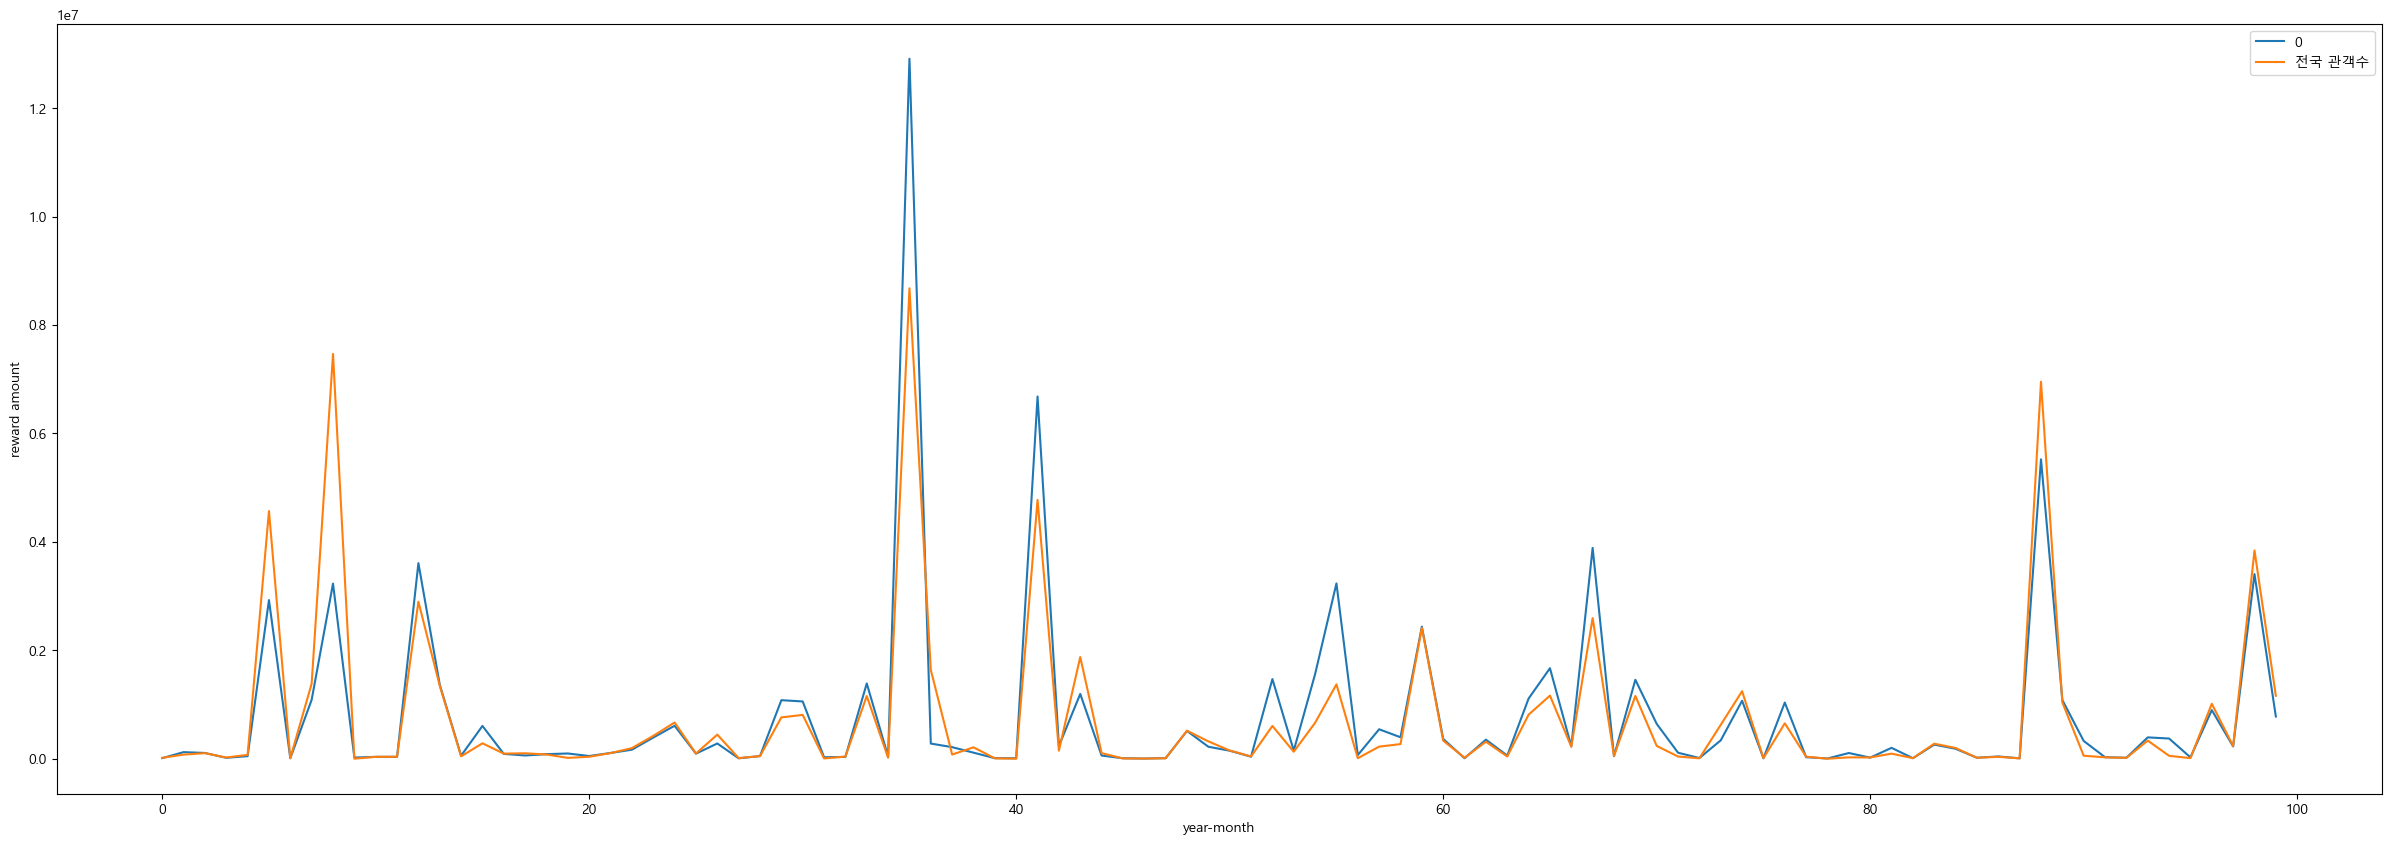

In [39]:
y_pred_df = pd.DataFrame(y_pred)
y_test_df = pd.DataFrame(y_test)
y_test_sort_index = y_test_df.sort_index(ascending=True)
y_test_sort_index = y_test_sort_index.reset_index(drop=True)
y_test_reset_index = y_test_df.reset_index(drop=True)
result2 = pd.concat([y_pred_df, y_test_reset_index], axis=1)
result2_subset = result2.iloc[:100]
result2_subset.plot(figsize=(30,10), xlabel='year-month', ylabel='reward amount')